In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/xAI-project-computer-vision

import sys
sys.path.insert(0,'/content/drive/My Drive/Github/xAI-project-computer-vision')

%pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Rc4yOY9-4nyo4PuPOLW54tnaNHAfWufd/Github/xAI-project-computer-vision


'/content/drive/.shortcut-targets-by-id/1Rc4yOY9-4nyo4PuPOLW54tnaNHAfWufd/Github/xAI-project-computer-vision'

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import random
import datetime

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [ ]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')

seed_all(42)

Random seed 42 has been set.


In [ ]:
import multiprocessing

num_classes = 10

# Hyperparameters
batch_size = 64
num_workers = multiprocessing.cpu_count() if not torch.cuda.is_available() else 2
num_epochs = 10
lr = 0.001
n_neighbors = 5

In [ ]:
from utils import get_available_device, move_to_device, DeviceDataLoader

device = get_available_device()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
import models

class FeatureExtractorCNN(nn.Module):
    def __init__(self, model):
        super(FeatureExtractorCNN, self).__init__()
        self.model = model
        self.embeddings = nn.Sequential(*list(self.model.children())[:-1]) # These are feature vectors/embeddings from the second-to-last (fully connected) layer of the architecture that will be extracted for kNN classification

        # Find the last fully connected layer
        last_fc_layer = None
        for module in reversed(list(self.model.children())):
            if isinstance(module, nn.Linear):
                last_fc_layer = module
                break

        if last_fc_layer is not None:
            print(last_fc_layer)
            in_features = last_fc_layer.in_features
            self.model.fc = nn.Linear(in_features, num_classes)
            self.fc = self.model.fc

    def forward(self, x):
        print("Shape before embeddings:", x.shape)
        x = self.embeddings(x)
        print("Shape after embeddings:", x.shape)
        x = x.view(x.size(0), -1)
        print("Shape after view:", x.shape)
        x = self.model.fc(x)
        print("Shape after fc:", x.shape)
        return x

def extract_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, target in dataloader:
            print("Input Shape:", inputs.shape)

            if hasattr(model, 'get_embeddings') and callable(getattr(model, 'get_embeddings')):
                outputs = model.get_embeddings(inputs)
            else:
                outputs = model.embeddings(inputs)

            print("Embedding Output Shape:", outputs.shape)
            # Flatten the 3D array into 2D
            outputs = outputs.view(outputs.size(0), -1)
            print("Embedding Output Shape after View:", outputs.shape)
            embeddings.append(outputs.cpu().numpy())
            labels.append(target.cpu().numpy())

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # split training/test datasets and prepare data loaders
    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Move all the tensors to GPU if available
    train_dl = DeviceDataLoader(train_loader, device)
    test_dl = DeviceDataLoader(test_loader, device)

    return train_dl, test_dl

def train_knn_classifier(features, labels):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(features, labels)
    return classifier

def evaluate_knn_classifier(classifier, test_features, test_labels):
    predictions = classifier.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

def visualize_results(model, test_dl, knn_classifier):
    model.eval()
    dataiter = iter(test_dl)
    images, labels = next(dataiter)
    images = move_to_device(images, device)

    with torch.no_grad():
        # Extract embeddings using the feature extractor
        if hasattr(model, 'get_embeddings') and callable(getattr(model, 'get_embeddings')):
                embeddings = model.get_embeddings(images)
        else:
            embeddings = model.embeddings(images)

        #embeddings = model.embeddings(images)
        flattened_embeddings = embeddings.view(embeddings.size(0), -1).cpu().numpy()

        # Predict labels using kNN classifier
        predictions = knn_classifier.predict(flattened_embeddings)

    # get the image classes
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Visualize sample test results
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
        image = images[idx].cpu().numpy()
        imshow(image)
        ax.set_title("{} (True: {})".format(classes[predictions[idx]], classes[labels[idx]]),
                     color=("green" if predictions[idx] == labels[idx].item() else "red"))


# Load CIFAR-10 dataset
train_dl, test_dl = load_data()


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Instantiate the model
model_name = 'simple_convnet'
feature_extractor_model = models.get_model('simple_convnet', batch_size, num_classes)
#model = FeatureExtractorCNN(feature_extractor_model).to(device)

# Train the model and extract features
#results = train(model, train_dl, num_epochs, lr, loss_func, optimizer)
train_features, train_labels = extract_embeddings(feature_extractor_model, train_dl)

# Save features and labels to a .npz file
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
np.savez(f'embeddings/cifar10/train_{model_name}_{current_datetime}.npz', features=train_features, labels=train_labels)

# Train KNN classifier on the extracted features
knn_classifier = train_knn_classifier(train_features, train_labels)

# Evaluate KNN classifier on the test set
test_features, test_labels = extract_embeddings(feature_extractor_model, test_dl)
knn_accuracy = evaluate_knn_classifier(knn_classifier, test_features, test_labels)
print(f"KNN Classifier Accuracy on Test Set: {knn_accuracy * 100:.2f}%")


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]       18,496               True
├─MaxPool2d (pool)                       [64, 64, 8, 8]       [64, 64, 4, 4]       --                   --
├─Dropout (dropout)                      [64, 1024]           [64, 1024]           --                   --
├─Linear (fc1)        

Flattened embedding shape: (64, 500)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)
Image shape after transpose: (3, 32, 32)


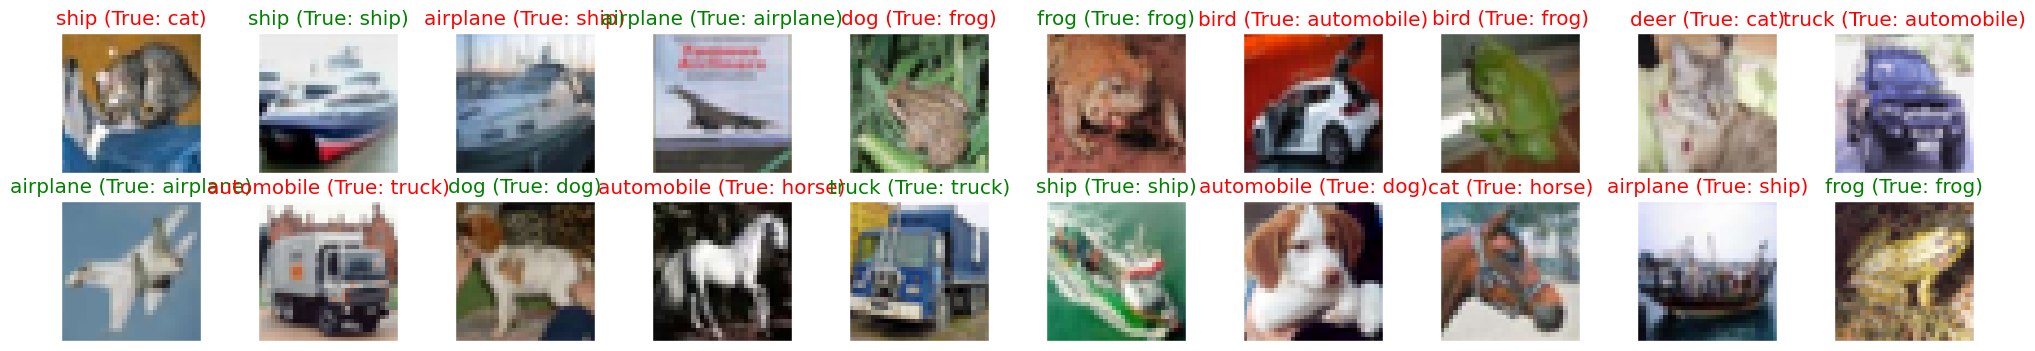

In [ ]:
# Visualize sample test results
visualize_results(feature_extractor_model, test_dl, knn_classifier)

In [ ]:
# Instantiate the model
output_folder = 'cifar10'

model_name = 'resnet50_fine_tuned'
feature_extractor_model = models.get_model(model_name, batch_size, num_classes)
best_model_cp = torch.load(f'outputs/{output_folder}/best_model_{model_name}_{output_folder}.pth')
feature_extractor_model.load_state_dict(best_model_cp['model_state_dict'])
model = FeatureExtractorCNN(feature_extractor_model).to(device)

# Train the model and extract features
train_features, train_labels = extract_embeddings(model, train_dl)

# Save features and labels to a .npz file
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
np.savez(f'embeddings/{output_folder}/train_{model_name}_{current_datetime}.npz', features=train_features, labels=train_labels)

# Train KNN classifier on the extracted features
knn_classifier = train_knn_classifier(train_features, train_labels)

# Evaluate KNN classifier on the test set
test_features, test_labels = extract_embeddings(model, test_dl)
knn_accuracy = evaluate_knn_classifier(knn_classifier, test_features, test_labels)
print(f"KNN Classifier Accuracy on Test Set: {knn_accuracy * 100:.2f}%")

Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1

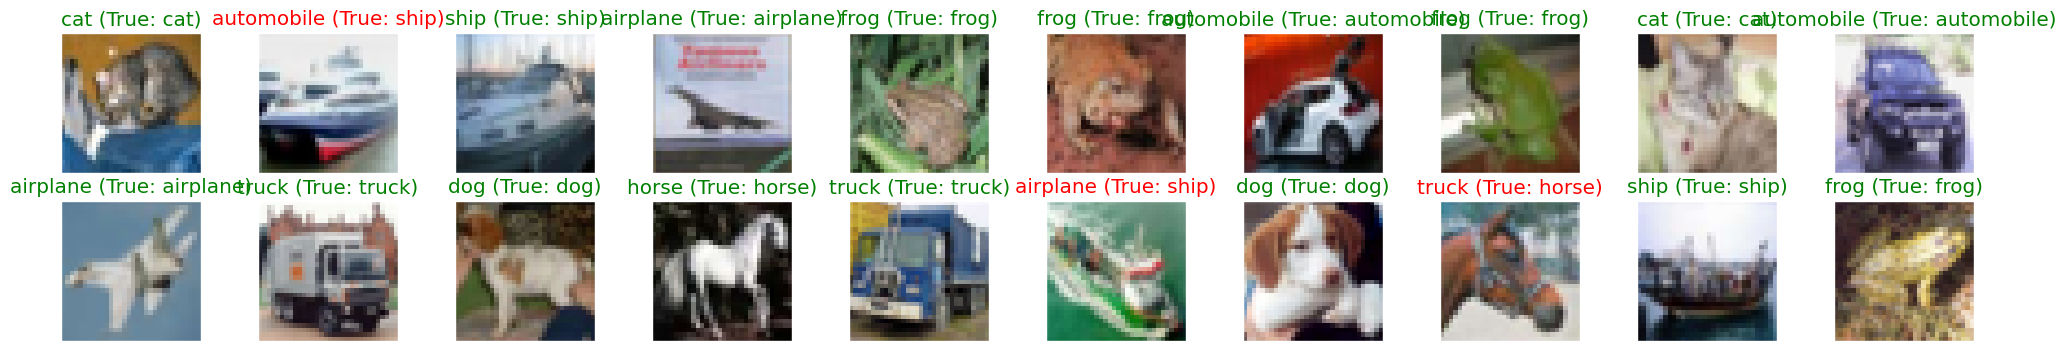

In [ ]:
# Visualize sample test results
visualize_results(model, test_dl, knn_classifier)

In [ ]:
# Instantiate the model
model_name = 'resnet50_custom'
feature_extractor_model = models.get_model(model_name, batch_size, num_classes)
model = FeatureExtractorCNN(feature_extractor_model).to(device)

# Train the model and extract features
#results = train(model, train_dl, num_epochs, lr, loss_func, optimizer)
train_features, train_labels = extract_embeddings(model, train_dl)

# Save features and labels to a .npz file
np.savez(f'embeddings/cifar10/train_{model_name}_{current_datetime}.npz', features=train_features, labels=train_labels)

# Train KNN classifier on the extracted features
#knn_classifier = train_knn_classifier(train_features, train_labels)

# Evaluate KNN classifier on the test set
#test_features, test_labels = extract_embeddings(model, test_dl)
#knn_accuracy = evaluate_knn_classifier(knn_classifier, test_features, test_labels)
#print(f"KNN Classifier Accuracy on Test Set: {knn_accuracy * 100:.2f}%")

# Visualize sample test results
#visualize_results(model, test_dl, knn_classifier)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    └─Bottleneck (0)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     4,096                True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


Linear(in_features=2048, out_features=1000, bias=True)
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 32, 32])
Embedding Output Shape: torch.Size([64, 2048, 1, 1])
Embedding Output Shape after View: torch.Size([64, 2048])
Input Shape: torch.Size([64, 3, 3

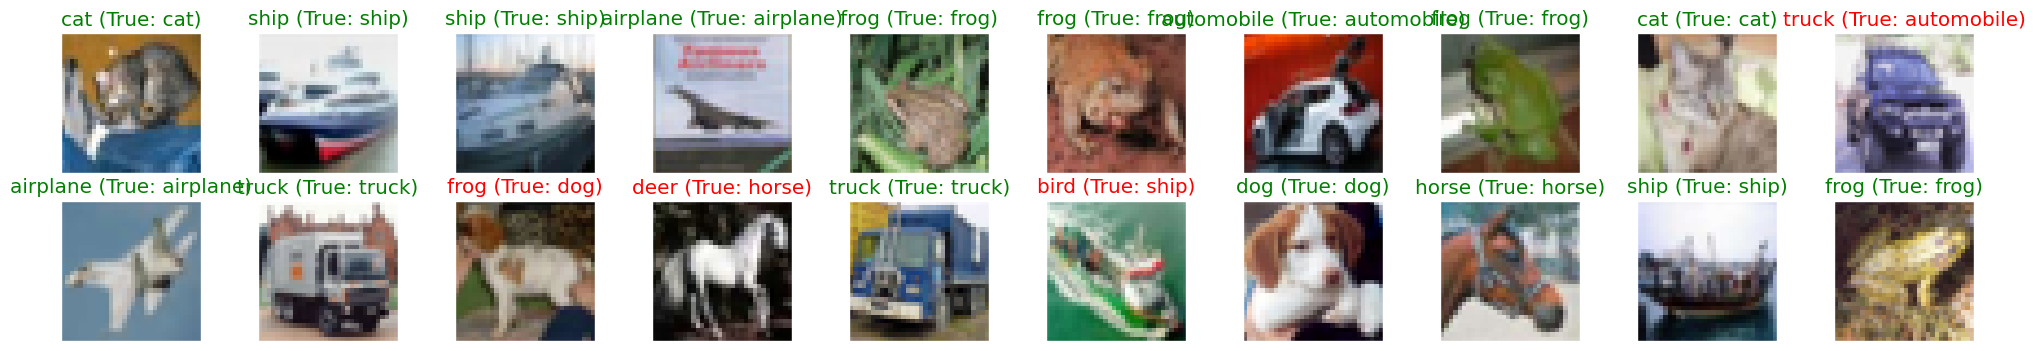

In [ ]:
# Instantiate the model
output_folder = 'cifar10'

feature_extractor_model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
model = FeatureExtractorCNN(feature_extractor_model).to(device)

# Train the model and extract features
#results = train(model, train_dl, num_epochs, lr, loss_func, optimizer)
train_features, train_labels = extract_embeddings(model, train_dl)

# Save features and labels to a .npz file
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
np.savez(f'embeddings/{output_folder}/train_resnet50_fine_tuned_pre_trained_weights_{current_datetime}.npz', features=train_features, labels=train_labels)

# Train KNN classifier on the extracted features
knn_classifier = train_knn_classifier(train_features, train_labels)

# Evaluate KNN classifier on the test set
test_features, test_labels = extract_embeddings(model, test_dl)
knn_accuracy = evaluate_knn_classifier(knn_classifier, test_features, test_labels)
print(f"KNN Classifier Accuracy on Test Set: {knn_accuracy * 100:.2f}%")

# Visualize sample test results
visualize_results(model, test_dl, knn_classifier)

In [ ]:
data = np.load('train_features.npz')
#data['features']
train_features, train_labels = data['features'], data['labels']
train_labels = [str(i) for i in train_labels]
train_labels
train_features.shape

(50000, 2048)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

Text(0.5, 1.0, 't-SNE')

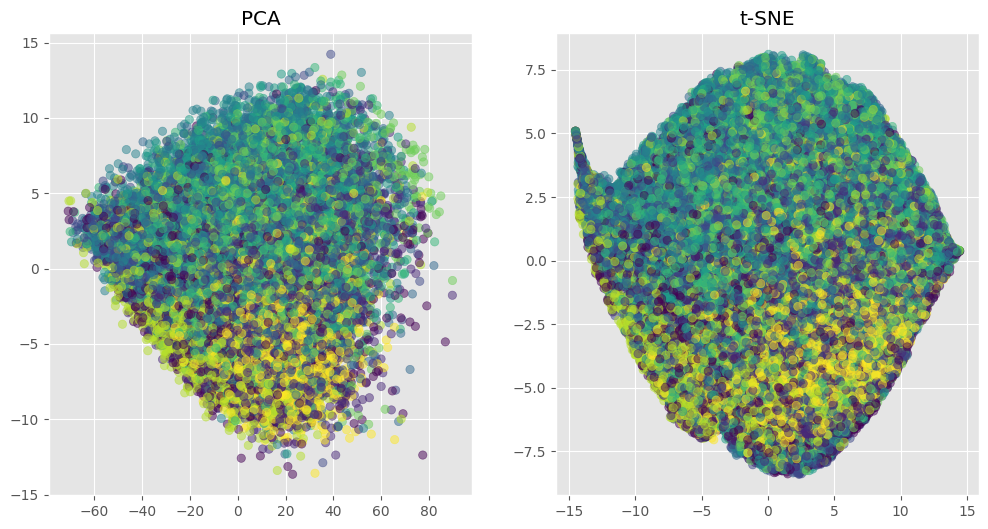

In [ ]:
# Load the embeddings from the saved .npz file
data = np.load('embeddings/cifar10/train_resnet50_fine_tuned.npz')
features = data['features']
labels = data['labels']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, verbose=0, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot PCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.5)
#sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='pastel', alpha=0.5)
plt.title('PCA')

# Plot t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.5)
#sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='pastel', alpha=0.5)
plt.title('t-SNE')


Text(0.5, 1.0, 't-SNE')

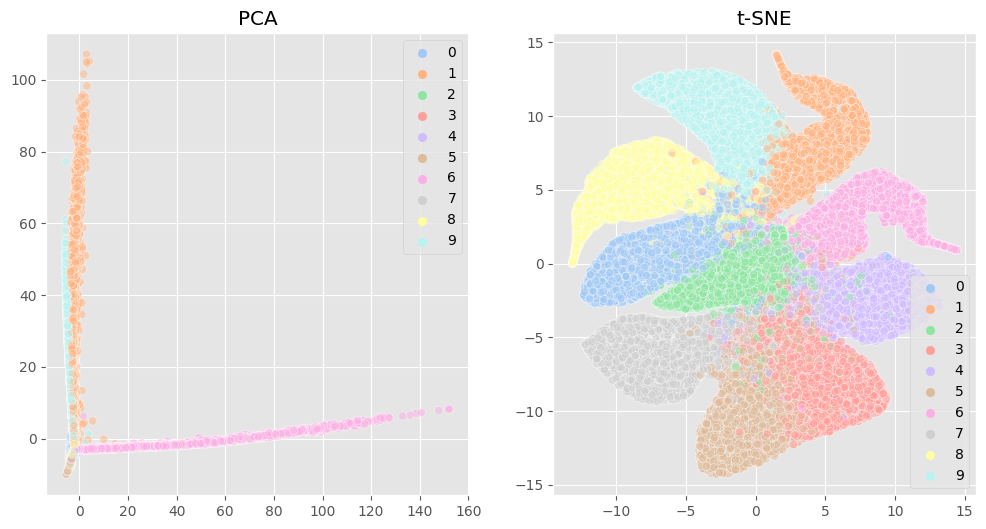

In [ ]:
# Load the embeddings from the saved .npz file
data = np.load('embeddings/cifar10/train_resnet50_fine_tuned_20231205_120824.npz')
features = data['features']
labels = data['labels']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, verbose=0, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot PCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='pastel', alpha=0.5)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='pastel', alpha=0.5)
plt.title('PCA')

# Plot t-SNE results
plt.subplot(1, 2, 2)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='pastel', alpha=0.5)
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='pastel', alpha=0.5)
plt.title('t-SNE')


In [ ]:
data = np.load('embeddings/DinoV2-CIFAR10-CIFAR100/CIFAR10-DINOV2-BASE/train.npz')
print(data.files)
for file_name in data.files:
    print(f"Content of '{file_name}':")
    print(data[file_name])

['filenames', 'embeddings', 'labels']
Content of 'filenames':
['train/airplane/0001.png' 'train/automobile/0001.png'
 'train/bird/0001.png' ... 'train/horse/5000.png' 'train/ship/5000.png'
 'train/truck/5000.png']
Content of 'embeddings':
[[ 2.6614726   0.3146976   0.58556503 ...  0.789015   -0.41249493
  -2.1164234 ]
 [-1.9632576   2.2300456   0.91191334 ... -1.3956066   2.265402
  -0.65940386]
 [ 2.6188345   2.3200498  -1.2740802  ... -1.1497295  -4.2312436
   0.8196967 ]
 ...
 [-0.64337206  0.9583536   0.39805895 ... -0.33306286 -1.1005741
   1.0050215 ]
 [ 2.308027    2.5297441   1.373849   ... -1.2146273  -2.8115127
  -0.9020616 ]
 [-0.20382962 -0.21846806 -0.09867624 ... -2.0240014  -1.5949901
  -0.50526494]]
Content of 'labels':
[0 0 0 ... 9 9 9]


Text(0.5, 1.0, 't-SNE')

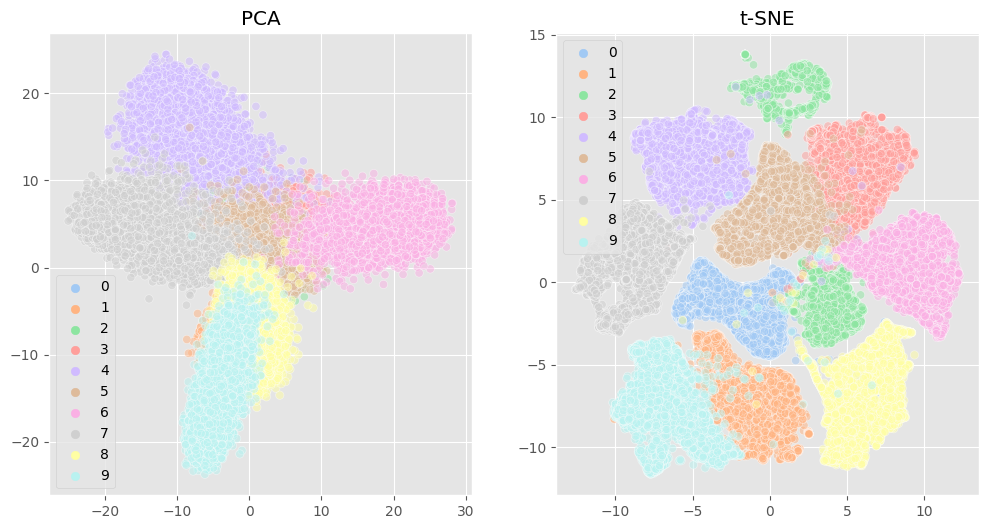

In [ ]:
# Load the embeddings from the saved .npz file
data = np.load('embeddings/DinoV2-CIFAR10-CIFAR100/CIFAR10-DINOV2-BASE/train.npz')
features = data['embeddings']
labels = data['labels']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, verbose=0, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot PCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='pastel', alpha=0.5)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='pastel', alpha=0.5)
plt.title('PCA')

# Plot t-SNE results
plt.subplot(1, 2, 2)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='pastel', alpha=0.5)
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='pastel', alpha=0.5)
plt.title('t-SNE')

Text(0.5, 1.0, 't-SNE')

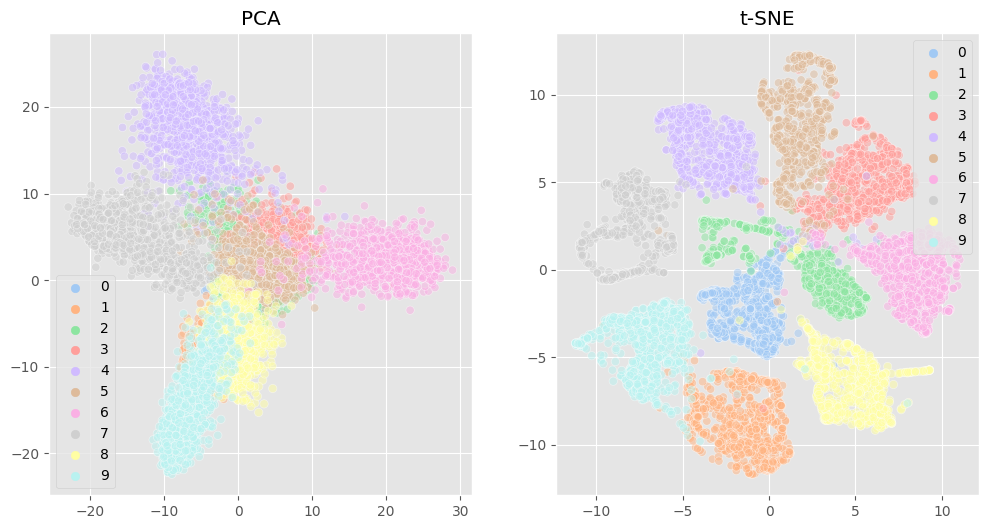

In [ ]:
# Load the embeddings from the saved .npz file
data = np.load('embeddings/DinoV2-CIFAR10-CIFAR100/CIFAR10-DINOV2-BASE/test.npz')
features = data['embeddings']
labels = data['labels']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, verbose=0, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot PCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='pastel', alpha=0.5)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='pastel', alpha=0.5)
plt.title('PCA')

# Plot t-SNE results
plt.subplot(1, 2, 2)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='pastel', alpha=0.5)
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='pastel', alpha=0.5)
plt.title('t-SNE')

In [ ]:
data = np.load('embeddings/DinoV2-CIFAR10-CIFAR100/CIFAR10-DINOV2-BASE/train.npz')
train_features = data['embeddings']
train_labels = data['labels']

data = np.load('embeddings/DinoV2-CIFAR10-CIFAR100/CIFAR10-DINOV2-BASE/test.npz')
test_features = data['embeddings']
test_labels = data['labels']

# Train KNN classifier on the extracted features
knn_classifier = train_knn_classifier(train_features, train_labels)

# Evaluate KNN classifier on the test set
#test_features, test_labels = extract_embeddings(model, test_dl) - No need because here we use the provided test set
knn_accuracy = evaluate_knn_classifier(knn_classifier, test_features, test_labels)
print(f"KNN Classifier Accuracy on Test Set: {knn_accuracy * 100:.2f}%")

# Visualize sample test results
#visualize_results(model, test_dl, knn_classifier)

KNN Classifier Accuracy on Test Set: 98.70%


In [ ]:
# Check if a GPU is available and use it for training
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the feature extractor model
class FeatureExtractorCNN(nn.Module):
    def __init__(self, model):
        super(FeatureExtractorCNN, self).__init__()
        self.model = model
        self.embeddings = nn.Sequential(*list(self.model.children())[:-1]) # These are feature vectors/embeddings from the second-to-last (fully connected?) layer of the architecture that will be extracted for kNN classification
        #self.fc = nn.Linear(2048, num_classes)

        # Modify the classifier for the desired number of classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.embeddings(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        return x

def extract_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, target in dataloader:
            outputs = model.embeddings(inputs)
            embeddings.append(outputs.cpu().numpy())
            labels.append(target.cpu().numpy())

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

def train_knn_classifier(features, labels):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(features, labels)
    return classifier

def evaluate_knn_classifier(classifier, test_features, test_labels):
    predictions = classifier.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# LATER: augment train and validation dataset with random image transformations
#train_transform = transforms.Compose([
#    transforms.RandomHorizontalFlip(), # randomly flip and rotate
#    transforms.RandomRotation(10),
#    transforms.ToTensor(),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#    ])

# Or:
#train_transform = transforms.Compose([
#    transforms.RandomRotation(30),
#    transforms.RandomHorizontalFlip(p=.30),
#    transforms.ToTensor(),
#    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # split training/test datasets and prepare data loaders
    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Move all the tensors to GPU if available
    train_dl = DeviceDataLoader(train_loader, device)
    test_dl = DeviceDataLoader(test_loader, device)

    return train_dl, test_dl
    #return train_data, test_data

def compute_accuracy(predicted, labels):
    predictions, predicted_labels = torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predicted_labels==labels).item()/len(predicted))

def train(model, train_dl, epochs, max_lr, loss_func, optimizer): # LATER: add parameter lr_scheduler
    # seed needed due to batch shuffling?
    seed_all(42)

    results = []

    for epoch in range(epochs):
        model.train()
        train_losses=[]
        train_accuracy_per_batch=[]
        lrs = []

        for batch_idx, (images, labels) in enumerate(train_dl):
            predicted = model(images)
            loss = loss_func(predicted,labels)
            train_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_accuracy_per_batch.append(compute_accuracy(predicted,labels))

            # logging
            if not batch_idx % 120:
                print (f'Epoch: {epoch+1:03d}/{epochs:03d} | '
                      f'Batch {batch_idx:03d}/{len(train_dl):03d} | '
                      f'Loss: {loss:.4f}')

        # LATER:
        #lr_scheduler.step()

        # no need to build the computation graph for backprop when computing accuracy
        with torch.set_grad_enabled(False):
            epoch_train_acc = torch.stack(train_accuracy_per_batch).mean().item()
            epoch_train_loss = torch.stack(train_losses).mean().item()

        results.append({'avg_train_loss': epoch_train_loss,
                        'avg_train_acc': epoch_train_acc,
                        'lrs':lrs})

        # print training/validation statistics
        print(f'Epoch: {epoch+1:03d}/{epochs:03d}   Train Loss: {epoch_train_loss:.2f} | Train Acc.: {epoch_train_acc:.2f}%')

    return results

def main():
    # Load CIFAR-10 dataset
    train_dl, test_dl = load_data()

    #train_data, test_data = load_data()
    #train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    #test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    #train_dl = DeviceDataLoader(train_loader, device)
    #test_dl = DeviceDataLoader(test_loader, device)

    # Instantiate the model, loss function, and optimizer
    feature_extractor_model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
    model = FeatureExtractorCNN(feature_extractor_model).to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model and extract features
    #results = train(model, train_dl, num_epochs, lr, loss_func, optimizer)
    train_features, train_labels = extract_embeddings(model, train_dl)

    # Save features and labels to a .npz file
    np.savez('train_features.npz', features=train_features, labels=train_labels)

    # Train KNN classifier on the extracted features
    knn_classifier = train_knn_classifier(train_features, train_labels)

    # Evaluate KNN classifier on the test set
    test_features, test_labels = extract_embeddings(model, test_dl)
    knn_accuracy = evaluate_knn_classifier(knn_classifier, test_features, test_labels)
    print(f"KNN Classifier Accuracy on Test Set: {knn_accuracy * 100:.2f}%")

if __name__ == "__main__":
    main()


Files already downloaded and verified
Files already downloaded and verified
Epoch: 001/020 | Batch 000/1563 |Loss: 2.3494
Epoch: 001/020 | Batch 120/1563 |Loss: 1.4884
Epoch: 001/020 | Batch 240/1563 |Loss: 1.1110
Epoch: 001/020 | Batch 360/1563 |Loss: 0.7131
Epoch: 001/020 | Batch 480/1563 |Loss: 1.0045
Epoch: 001/020 | Batch 600/1563 |Loss: 1.0978
Epoch: 001/020 | Batch 720/1563 |Loss: 0.9077
Epoch: 001/020 | Batch 840/1563 |Loss: 1.1728
Epoch: 001/020 | Batch 960/1563 |Loss: 1.2233
Epoch: 001/020 | Batch 1080/1563 |Loss: 1.3581
Epoch: 001/020 | Batch 1200/1563 |Loss: 0.6208
Epoch: 001/020 | Batch 1320/1563 |Loss: 0.6453
Epoch: 001/020 | Batch 1440/1563 |Loss: 0.6840
Epoch: 001/020 | Batch 1560/1563 |Loss: 0.6206
Epoch: 001/020   Train Loss: 1.00 | Train Acc.: 0.67%
Epoch: 002/020 | Batch 000/1563 |Loss: 0.7442
Epoch: 002/020 | Batch 120/1563 |Loss: 0.5254
Epoch: 002/020 | Batch 240/1563 |Loss: 0.6862
Epoch: 002/020 | Batch 360/1563 |Loss: 0.8966
Epoch: 002/020 | Batch 480/1563 |Loss

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchinfo import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [ ]:
tsne = TSNE(n_components=2, verbose=0, random_state=42)
x_tsne_dino = tsne.fit_transform

sns.scatterplot(x=x_tsne_dino[:,0], y=x_tsne_dino[:,1], hue=y_train_dino, palette="pastel".set(title="WideResNet50"))